# Cluster Based Heuristics for Data Labelling

Exploiting Cluster Structure in data to get labelling for unlabelled data.

Steps to be followed:
- Find a clustering of the data
- Sample a few randomly-chosen points in each cluster
- Assign each cluster its majority label
- Now use this fully labelled data set to build a classifier

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

In [2]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=2)
transformed_iris = pca.fit_transform(X=X_raw)

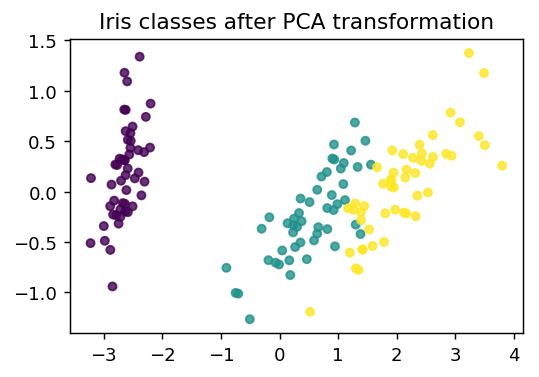

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(4.5, 3), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=20, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

In [4]:
import numpy as np
np.random.seed(154)

n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size = 3)
pool_indices = np.delete(np.arange(0, n_labeled_examples, 1), training_indices)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

## Training Learner model with Initial Labelling Data

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from learner import ActiveLearner
from sklearn import svm

# Specify model along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors = 3)
learner = ActiveLearner(models = [knn], strategy = "uncertainity", uncertainity_measure = "lc")

In [6]:
learner.teach(X_train, y_train)

In [7]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

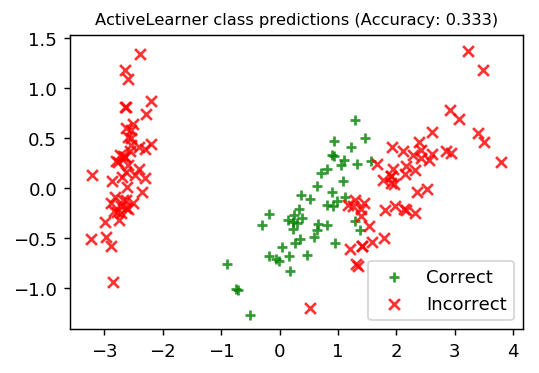

In [8]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(4.5, 3), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score), fontsize=9)
plt.show()

## Fitting a cluster model to the Unlabelled Data

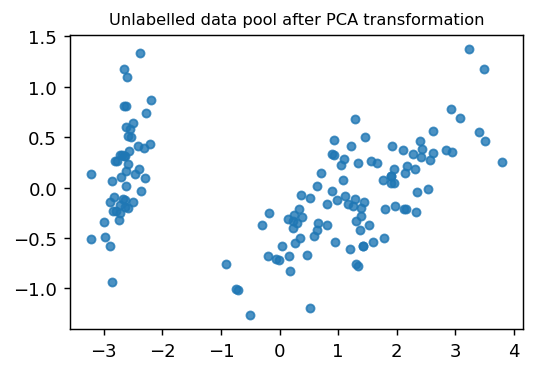

In [9]:
# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(4.5, 3), dpi=130)
plt.scatter(x = x_component[pool_indices], y = y_component[pool_indices], cmap='viridis', s=20, alpha=8/10)
plt.title('Unlabelled data pool after PCA transformation', fontsize = 9)
plt.show()

In [10]:
from sklearn.cluster import KMeans

# Specify model for clustering
kmeans = KMeans(n_clusters = 3, random_state=0).fit(X_pool)

#clustering ouput
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

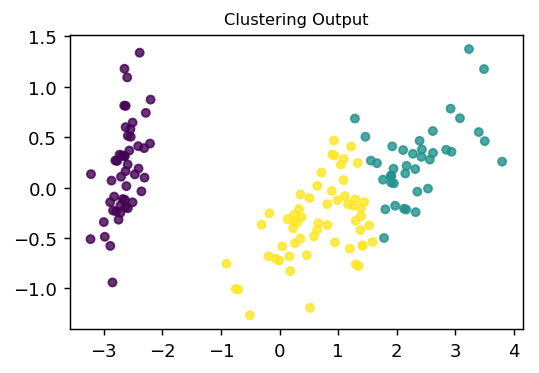

In [11]:
# Plot clustering output
plt.figure(figsize=(4.5, 3), dpi=130)
plt.scatter(x = x_component[pool_indices], y = y_component[pool_indices], c = kmeans.labels_, cmap='viridis', s=20, alpha=8/10)
plt.title('Clustering Output', fontsize = 9)
plt.show()

In [12]:
# Select 3 random points in each cluster
cluster1 = X_pool[kmeans.labels_ == 0]
y_pool_1 = y_pool[kmeans.labels_ == 0]
cluster2 = X_pool[kmeans.labels_ == 1]
y_pool_2 = y_pool[kmeans.labels_ == 1]
cluster3 = X_pool[kmeans.labels_ == 2]
y_pool_3 = y_pool[kmeans.labels_ == 2]

index1 = np.random.choice(cluster1.shape[0], 5, replace=False)
index2 = np.random.choice(cluster2.shape[0], 5, replace=False)
index3 = np.random.choice(cluster3.shape[0], 5, replace=False)

In [13]:
# Get labels from oracle and assign majority label to clusters
labels1 = y_pool_1[index1]
labels2 = y_pool_2[index2]
labels3 = y_pool_3[index3]

print('Labels for Cluster 1 points =', labels1)
print('Labels for Cluster 2 points =', labels2)
print('Labels for Cluster 3 points =', labels3)

#Take majority voting and assign labels to each cluster
(values, counts) = np.unique(labels1, return_counts=True)
ind = np.argmax(counts)
assigned_label1 = values[ind]

(values, counts) = np.unique(labels2, return_counts=True)
ind = np.argmax(counts)
assigned_label2 = values[ind]

(values, counts) = np.unique(labels3, return_counts=True)
ind = np.argmax(counts)
assigned_label3 = values[ind]

print("Cluster 1 Label :", assigned_label1)
print("Cluster 2 Label :", assigned_label2)
print("Cluster 3 Label :", assigned_label3)

Labels for Cluster 1 points = [0 0 0 0 0]
Labels for Cluster 2 points = [2 2 1 2 2]
Labels for Cluster 3 points = [1 1 1 1 2]
Cluster 1 Label : 0
Cluster 2 Label : 2
Cluster 3 Label : 1


## Teach Leaner Model with the Labelled data obtained from Clustering

In [14]:
X = X_pool
y = np.zeros(len(X_pool))
y[kmeans.labels_ == 0] = assigned_label1
y[kmeans.labels_ == 1] = assigned_label2
y[kmeans.labels_ == 2] = assigned_label3

In [15]:
learner.teach(X=X, y=y)

# Calculate and report our model's accuracy.
model_accuracy = learner.score(X_raw, y_raw)
print('Accuracy: {acc:0.4f}'.format(acc=model_accuracy))

Accuracy: 0.8867


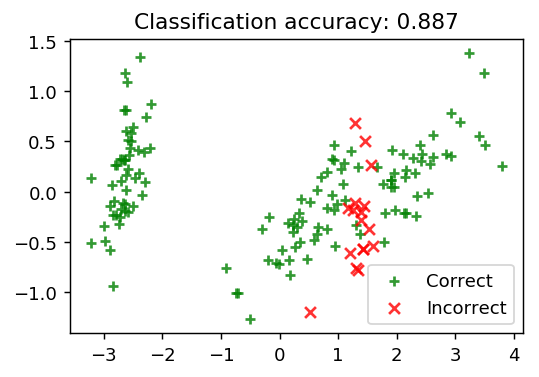

In [16]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(4.5, 3), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy: {final_acc:.3f}'.format(final_acc=model_accuracy))
ax.legend(loc='lower right')

plt.show()